# Positron Emission Tomography (PET) reconstruction with Distributional Consistency (DC) loss (regularized)
### Code for plotting figures

## Setup

In [1]:
# --- Set up import path ---
import sys, os

cwd = os.getcwd()
if os.path.isdir(os.path.join(cwd, 'src')):
    repo_root = cwd
elif os.path.isdir(os.path.join(cwd, '..', 'src')):
    repo_root = os.path.abspath(os.path.join(cwd, '..'))
else:
    raise RuntimeError('Could not find repo root (expected a src/ directory).')

src_path = os.path.join(repo_root, 'src')
sys.path.insert(0, src_path)
print(f'Repo root: {repo_root}')


Repo root: c:\Users\gw23\git\DC-loss-open-source\DC-Loss


In [2]:
# --- Import libraries ---
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import numpy as np
import scipy
from scipy.ndimage import binary_fill_holes
import array_api_compat.torch as torch
import pickle
import glob

from utils.phantom import get_brainweb_phantom
from utils.plotting import plot_CDF_histogram, hide
from utils.metrics import *
from utils.projector import get_projector, get_binmashed_projector_forward_function, get_binmashed_projector_adjoint_function
from utils.losses import dc_loss_poisson
from utils.common_utils import fix_seed

plt.rcParams['image.interpolation'] = 'none'


          -  -  -  -  -  -  -  -   -  -  -  -
          P  A  R  A  L  L  E  L | P  R  O  J
          -  -  -  -  -  -  -  -   -  -  -  -


         Please consider citing our publication
      ---------------------------------------------
      Georg Schramm and Kris Thielemans:
      "PARALLELPROJ—an open-source framework for
       fast calculation of projections in
       tomography"
      Front. Nucl. Med., 08 January 2024
      Sec. PET and SPECT, Vol 3
      https://doi.org/10.3389/fnume.2023.1324562

 
    parallelproj C    lib: C:\Users\gw23\AppData\Local\miniforge3\envs\recon_pipeline\Library\bin\parallelproj_c.dll
    parallelproj CUDA lib: C:\Users\gw23\AppData\Local\miniforge3\envs\recon_pipeline\Library\bin\parallelproj_cuda.dll
    


In [3]:
# --- Parameters ---
dev = "cpu"
PHANTOM_NAME = "brainweb"
SAVEFIG = True
DOSE = 5.0 # 2
IMG_SIZE = 256
BINMASH = 2
seed = 0
pseed = 0
prior = "edge_tv"

save_directory = os.path.join(repo_root, "figures", "PET", "reg")
os.makedirs(save_directory, exist_ok=True)


In [4]:
import brainweb as bw
import numpy as np
from skimage.transform import resize

def get_brainweb_phantom(n = 256, ix=0, slice=160):
	 # Make *** PET FDG *** from slice 160 of the 3D tissue map
	tissue = np.pad(bw.load_file(bw.get_files()[ix]), ((0,0), (12,12), (48,48))).astype('f4')
	white_matter = (tissue == 48);  grey_matter = (tissue == 32);  skin = (tissue == 96)
	pet = np.zeros_like(tissue); pet[white_matter]=32; pet[grey_matter]=96; pet[skin]=16
	true = np.flipud(resize(pet[slice,:,:], (n,n)))
	return true / 200.0


In [5]:

def total_variation_penalty(image):
    # Compute horizontal and vertical gradients
    dx = image[:, :, :, 1:] - image[:, :, :, :-1]  # Horizontal differences
    dy = image[:, :, 1:, :] - image[:, :, :-1, :]  # Vertical differences

    # Compute the total variation (L1 norm of gradients)
    tv_penalty = torch.mean(torch.abs(dx)) + torch.mean(torch.abs(dy))
    return tv_penalty

import torch

def edge_aware_tv(image, kappa=0.1, eps=1e-8):
    """
    Edge-aware TV with Perona–Malik weights on the common inner grid.
    image: (N, C, H, W)
    """
    # Forward differences
    dx = image[:, :, :, 1:] - image[:, :, :, :-1]   # (N,C,H,W-1)
    dy = image[:, :, 1:, :] - image[:, :, :-1, :]   # (N,C,H-1,W)

    # Restrict both to common shape (N,C,H-1,W-1)
    dx_i = dx[:, :, :-1, :]                         # (N,C,H-1,W-1)
    dy_i = dy[:, :, :, :-1]                         # (N,C,H-1,W-1)

    # Gradient magnitude and edge-stopping weights
    grad_mag = torch.sqrt(dx_i**2 + dy_i**2 + eps)
    weights = 1.0 / (1.0 + (grad_mag / kappa)**2)   # or: torch.exp(-(grad_mag/kappa)**2)

    # Weighted TV (L1 on gradients, weighted by edge mask)
    tv = torch.mean(weights * (torch.abs(dx_i) + torch.abs(dy_i)))
    return tv


In [6]:
# --- Load results ---
dose = DOSE * (IMG_SIZE/128)**2 / 4
phantom = torch.tensor(get_brainweb_phantom(n=IMG_SIZE).copy()).to(torch.float64)

phantom = phantom * dose
phantom = phantom[None, None, ..., None].to(dev).to(torch.float64)

true_tv_value = edge_aware_tv(phantom)

prior = "edge_tv"
beta = 0.0

candidate_load_dirs = [
    os.path.join(repo_root, "results", "PET_reg"),
    os.path.join(repo_root, "results", "PET"),  # backward compatibility
]
load_dir = next((d for d in candidate_load_dirs if os.path.isdir(d)), candidate_load_dirs[0])
print(f"Using results directory: {load_dir}")

filename = f"dose={dose}_scheduled=False_pseed={pseed}_seed={seed}_BINMASH={BINMASH}_IMGSIZE={IMG_SIZE}_prior={prior}_beta={beta}_v2.pkl"
file_path = os.path.join(load_dir, filename)
print(f"Loading: {file_path}")
states = pickle.load(open(file_path, "rb"))

epochs = 10001


BrainWeb Subjects:   0%|          | 0/20 [00:00<?, ?file/s]

Using results directory: c:\Users\gw23\git\DC-loss-open-source\DC-Loss\results\PET_reg
Loading: c:\Users\gw23\git\DC-loss-open-source\DC-Loss\results\PET_reg\dose=5.0_scheduled=False_pseed=0_seed=0_BINMASH=2_IMGSIZE=256_prior=edge_tv_beta=0.0_v2.pkl


In [7]:
import glob

nll_tv_nrmses = []
nll_perfect_nrmses = []
dist_tv_nrmses = []
dist_perfect_nrmses = []

dist_tv_betas = []
nll_tv_betas = []
dist_tv_priors = []
nll_tv_priors = []
dist_tv_dc = []
nll_tv_dc = []
dist_tv_nll = []
nll_tv_nll = []
dist_tv_ssim = []
nll_tv_ssim = []

dist_images = []
nll_images = []

states_min_nrmse = {}

#
betas = [0.0, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] # , 10000.0, 100000.0, 100000.0
#betas = [0.0, 0.001, 0.004, 0.01, 0.04, 0.1, 0.4, 1.0, 4.0, 10.0, 40.0, 100.0, 400.0, 1000.0, 4000.0, 10000.0, 40000.0, 100000.0]

for prior in ["edge_tv"]: # "perfect", , "perfect"
    pattern = os.path.join(load_dir, f"dose={dose}_scheduled=False_pseed={pseed}_seed={seed}_BINMASH={BINMASH}_IMGSIZE={IMG_SIZE}_prior={prior}_beta=*_v2.pkl")
    for file_path in glob.glob(pattern):
        states = pickle.load(open(file_path, "rb"))
        file_name = os.path.basename(file_path)
        if "nll" in states:
            beta_value = float(file_name.split("_beta=")[-1].split("_")[0])
            nll_tv_betas.append(beta_value)
            nrmse_nll = states["nll"]["losses"]["nrmse"]
            if prior == "perfect":
                nll_perfect_nrmses.append(nrmse_nll.min())
            else:
                #arg = nrmse_nll.argmin()
                arg = -1
                nll_tv_nrmses.append(nrmse_nll[arg])
                last_im = states["nll"]["last_image"]
                nll_tv_priors.append(edge_aware_tv(torch.tensor(last_im).unsqueeze(0).unsqueeze(0)))
                #nll_tv_priors.append(states["nll"]["losses"]["prior_loss"][arg])
                nll_tv_dc.append(states["nll"]["losses"]["dist_loss"][arg])
                nll_tv_nll.append(states["nll"]["losses"]["nll_loss"][arg])
                nll_tv_ssim.append(states["nll"]["losses"]["ssim"][arg])

                if states["nll"]["losses"]["nll_loss"][-1] < 190000:
                    last_im_nll = last_im

                nll_images.append(last_im)

                if (not ("nll" in states_min_nrmse)) or (nrmse_nll[arg] < states_min_nrmse["nll"]["losses"]["nrmse"][-1]):
                    states_min_nrmse["nll"] = states["nll"]
                    print("nll", arg)
        if "dist" in states:
            nrmse_dc = states["dist"]["losses"]["nrmse"]
            beta_value = float(file_name.split("_beta=")[-1].split("_")[0])
            dist_tv_betas.append(beta_value)
            if prior == "perfect":
                dist_perfect_nrmses.append(nrmse_dc.min())
            else:
                #arg = nrmse_dc.argmin()
                arg = -1
                last_im_dc = states["dist"]["last_image"]
                dist_tv_nrmses.append(nrmse_dc[arg])
                dist_tv_priors.append(edge_aware_tv(torch.tensor(last_im_dc).unsqueeze(0).unsqueeze(0)))
                dist_tv_dc.append(states["dist"]["losses"]["dist_loss"][arg])
                dist_tv_nll.append(states["dist"]["losses"]["nll_loss"][arg])
                dist_tv_ssim.append(states["dist"]["losses"]["ssim"][arg])
                if (not ("dist" in states_min_nrmse)) or (nrmse_dc[arg] < states_min_nrmse["dist"]["losses"]["nrmse"][-1]):
                    states_min_nrmse["dist"] = states["dist"]
                    last_im_dc = states["dist"]["last_image"]

                dist_images.append(last_im_dc)

epochs = 10001


nll -1
nll -1
nll -1
nll -1
nll -1
nll -1
nll -1
nll -1


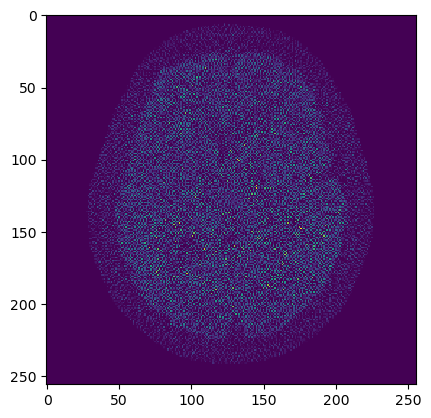

In [8]:
plt.imshow(last_im_nll.squeeze())

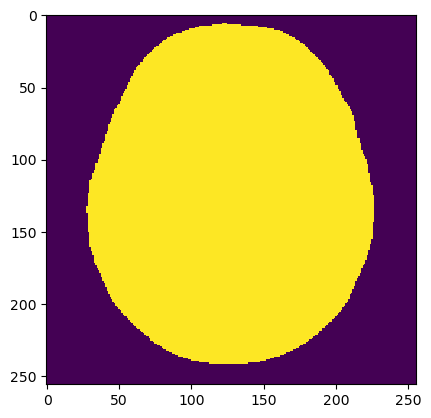

In [9]:
plt.imshow(last_im_dc.squeeze())

In [10]:
import numpy as np

# Convert lists to numpy arrays
nll_tv_betas = np.array(nll_tv_betas)
nll_tv_nrmses = np.array(nll_tv_nrmses)
nll_tv_priors = np.array(nll_tv_priors)
nll_tv_dc = np.array(nll_tv_dc)
nll_tv_nll = np.array(nll_tv_nll)
nll_tv_ssim = np.array(nll_tv_ssim)

dist_tv_betas = np.array(dist_tv_betas)
dist_tv_nrmses = np.array(dist_tv_nrmses)
dist_tv_priors = np.array(dist_tv_priors)
dist_tv_dc = np.array(dist_tv_dc)
dist_tv_nll = np.array(dist_tv_nll)
dist_tv_ssim = np.array(dist_tv_ssim)

# Get sorting order for nll betas
nll_sort_order = np.argsort(nll_tv_betas)
dc_sort_order = np.argsort(dist_tv_betas)

# Apply sorting order to NLL arrays
nll_tv_betas = nll_tv_betas[nll_sort_order]
nll_tv_nrmses = nll_tv_nrmses[nll_sort_order]
nll_tv_priors = nll_tv_priors[nll_sort_order]
nll_tv_dc = nll_tv_dc[nll_sort_order]
nll_tv_nll = nll_tv_nll[nll_sort_order]
nll_tv_ssim = nll_tv_ssim[nll_sort_order]

nll_images = [nll_images[i] for i in nll_sort_order]

# Apply sorting order to DC arrays
dist_tv_betas = dist_tv_betas[dc_sort_order]
dist_tv_nrmses = dist_tv_nrmses[dc_sort_order]
dist_tv_priors = dist_tv_priors[dc_sort_order]
dist_tv_dc = dist_tv_dc[dc_sort_order]
dist_tv_nll = dist_tv_nll[dc_sort_order]
dist_tv_ssim = dist_tv_ssim[dc_sort_order]

dist_images = [dist_images[i] for i in dc_sort_order]

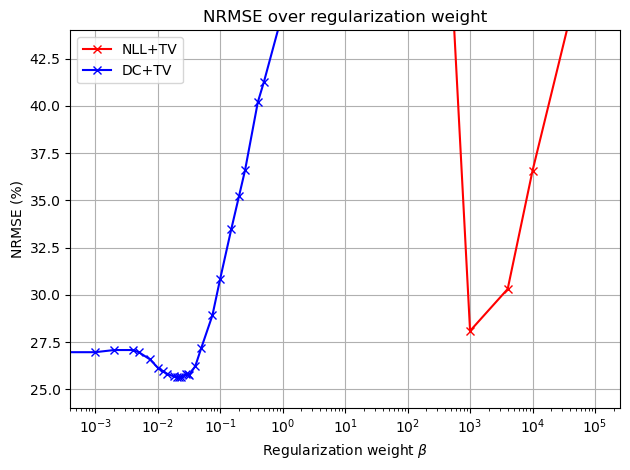

In [11]:
plt.plot(nll_tv_betas, nll_tv_nrmses*100.0, label="NLL+TV", color='red', marker='x')
plt.plot(dist_tv_betas, np.array(dist_tv_nrmses)*100.0, label="DC+TV", color='blue', marker='x')
#make the x axis log scale
plt.xscale("log")
plt.ylabel("NRMSE (%)")
ax = plt.gca()
ax.set_ylim([24, 44])
plt.xlabel(r"Regularization weight $\beta$")
plt.title("NRMSE over regularization weight")
plt.legend()
plt.grid(True, which="major", )
plt.tight_layout()
if SAVEFIG:
    plt.savefig(os.path.join(save_directory, f"edge_TV_beta_vs_nrmse.svg"))
plt.show()

In [12]:
min(nll_tv_nrmses*100.0), min(dist_tv_nrmses*100.0)

(28.08815563558521, 25.645669974257036)

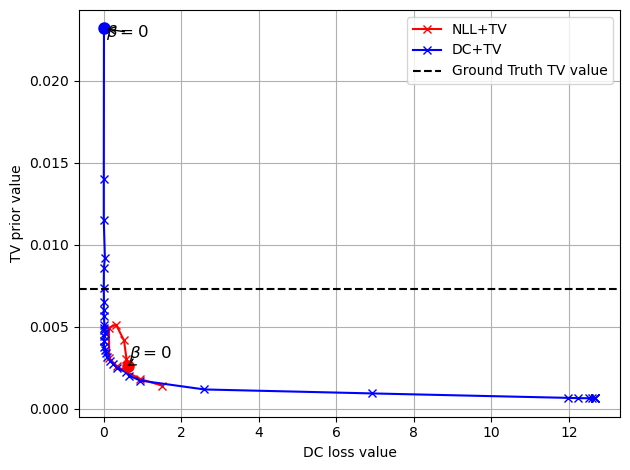

In [13]:
plt.plot(np.array(nll_tv_dc), np.array(nll_tv_priors), label="NLL+TV", color='red', marker='x')
plt.plot(np.array(dist_tv_dc), np.array(dist_tv_priors), label="DC+TV", color='blue', marker='x')
#make the x axis log scale
#plt.xscale("log")
plt.ylabel("TV prior value")
plt.xlabel(r"DC loss value")

# Highlight the smallest beta point with a square marker
plt.plot(nll_tv_dc[0], nll_tv_priors[0], marker='o', color='red', markersize=8, linestyle='None')
plt.plot(dist_tv_dc[0], dist_tv_priors[0], marker='o', color='blue', markersize=8, linestyle='None')
plt.annotate(r'$\beta = 0$', xy=(nll_tv_dc[0], nll_tv_priors[0]), xytext=(nll_tv_dc[0]+0.05, nll_tv_priors[0]+0.0005),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)
plt.annotate(r'$\beta = 0$', xy=(dist_tv_dc[0], dist_tv_priors[0]), xytext=(dist_tv_dc[0]+0.05, dist_tv_priors[0]-0.0005),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)

# plot horizontal line at true_tv_value
plt.axhline(y=true_tv_value.item(), color='black', linestyle='--', label='Ground Truth TV value')
ax = plt.gca()
#ax.set_xlim(0, 1)
plt.grid(True, which="major")
plt.legend()
plt.tight_layout()
if SAVEFIG:
    plt.savefig(os.path.join(save_directory, f"edge_TV_prior_vs_dc.svg"))
plt.show()

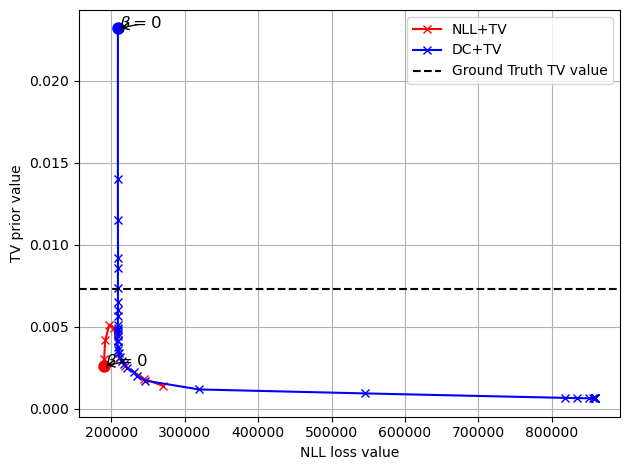

In [14]:
plt.plot(np.array(nll_tv_nll), np.array(nll_tv_priors), label="NLL+TV", color='red', marker='x')
plt.plot(np.array(dist_tv_nll), np.array(dist_tv_priors), label="DC+TV", color='blue', marker='x')
#make the x axis log scale
#plt.xscale("log")
plt.ylabel("TV prior value")
plt.xlabel(r"NLL loss value")


# Highlight the smallest beta point with a square marker
plt.plot(nll_tv_nll[0], nll_tv_priors[0], marker='o', color='red', markersize=8, linestyle='None')
plt.plot(dist_tv_nll[0], dist_tv_priors[0], marker='o', color='blue', markersize=8, linestyle='None')
plt.annotate(r'$\beta = 0$', xy=(nll_tv_nll[0], nll_tv_priors[0]), xytext=(nll_tv_nll[0]+2000.0, nll_tv_priors[0]),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)
plt.annotate(r'$\beta = 0$', xy=(dist_tv_nll[0], dist_tv_priors[0]), xytext=(dist_tv_nll[0]+2000.0, dist_tv_priors[0]),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)

# plot horizontal line at true_tv_value
plt.axhline(y=true_tv_value.item(), color='black', linestyle='--', label='Ground Truth TV value')
plt.legend()
plt.grid(True, which="major", )
plt.tight_layout()
if SAVEFIG:
    plt.savefig(os.path.join(save_directory, f"edge_TV_prior_vs_NLL.svg"))
plt.show()

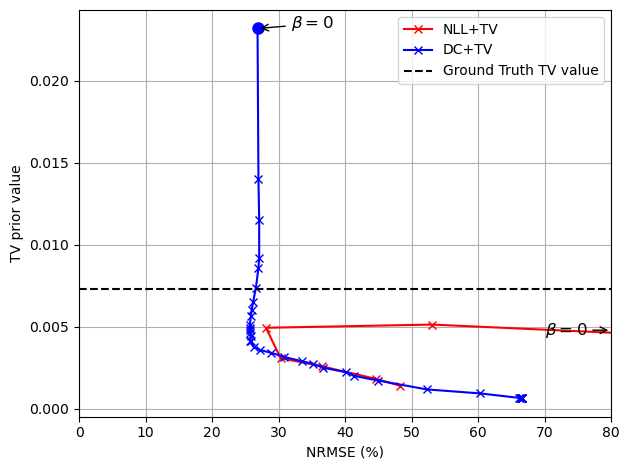

In [15]:

plt.plot(np.array(nll_tv_nrmses)*100, np.array(nll_tv_priors), label="NLL+TV", color='red', marker='x')
plt.plot(np.array(dist_tv_nrmses)*100, np.array(dist_tv_priors), label="DC+TV", color='blue', marker='x')
#make the x axis log scale
#plt.xscale("log")
plt.ylabel("TV prior value")
plt.xlabel(r"NRMSE (%)")
# plot horizontal line at true_tv_value
plt.axhline(y=true_tv_value.item(), color='black', linestyle='--', label='Ground Truth TV value')
plt.legend()






plt.xlim([0, 80])


# Highlight the smallest beta point with a square marker
plt.plot(nll_tv_nrmses[0]*100, nll_tv_priors[0], marker='o', color='red', markersize=8, linestyle='None')
plt.plot(dist_tv_nrmses[0]*100, dist_tv_priors[0], marker='o', color='blue', markersize=8, linestyle='None')
plt.annotate(
    r'$\beta = 0$', 
    xy=(plt.xlim()[1], 0.0048), 
    xytext=(plt.xlim()[1] - 10 , 0.0048),
    arrowprops=dict(facecolor='black', arrowstyle='->'), 
    fontsize=12,
    va='center'
)
plt.annotate(r'$\beta = 0$', xy=(dist_tv_nrmses[0]*100, dist_tv_priors[0]), xytext=(dist_tv_nrmses[0]*100+5.0, dist_tv_priors[0]),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)

plt.grid(True, which="major", )
plt.tight_layout()
#plt.title("At 2500 iterations for each method")
if SAVEFIG:
    plt.savefig(os.path.join(save_directory, f"edge_TV_prior_vs_nrmse.svg"))
plt.show()

## Plotting

In [16]:
states = states_min_nrmse

### Plot negative log-likelihood

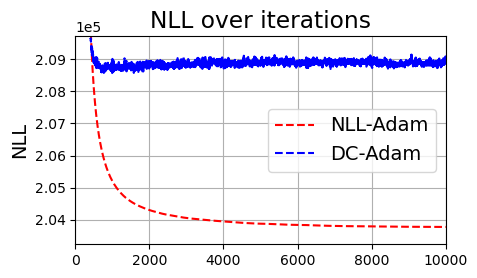

In [17]:
SAVEFIG=False
plt.rcParams.update({'font.size': 14})

cutoff = 0 #500  # Cutoff for the x-axis

x_values = list(range(0, epochs, 1))

x_values_dist = x_values[:len(states["dist"]["losses"]["nll_loss"])]

# Plot the NLL losses
fig, ax = plt.subplots(1, 1, figsize=(5,3))

ax.set_xlim(cutoff, x_values[-1])
ymin = states["nll"]["losses"]["nll_loss"][2000:].min()
ymax = states["dist"]["losses"]["nll_loss"][1000:].max()
ax.set_ylim(ymin - (ymax-ymin)*0.1, ymax + (ymax-ymin)*0.1 )

ax.plot(x_values[cutoff:], states["nll"]["losses"]["nll_loss"][cutoff:], label="NLL-Adam", color='red', linestyle='--')
ax.plot(x_values_dist[cutoff:], states["dist"]["losses"]["nll_loss"][cutoff:], label="DC-Adam", color='blue', linestyle='--')

ax.tick_params(axis='both', labelsize=10)
ax.ticklabel_format(axis='y', style="sci", scilimits=(0,0))
ax.set_title("NLL over iterations")
ax.yaxis.get_offset_text().set_fontsize(10)
ax.set_ylabel("NLL")
ax.grid(True)
ax.legend()
plt.tight_layout()

if SAVEFIG:
    plt.savefig(os.path.join(save_directory, f"IMG_SIZE_{IMG_SIZE}_PET_NLL_loss.svg"))

plt.show()

### Plot DC loss

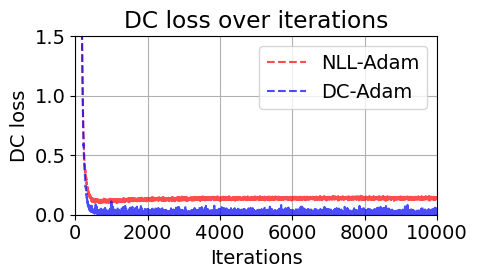

In [18]:
# Plot the loss curves
plt.rcParams.update({'font.size': 14})
cutoff = 0  # Cutoff for the x-axis

x_values = list(range(0, epochs, 1))

x_values_dist = x_values[:len(states["dist"]["losses"]["dist_loss"])]

# Plot the NLL losses
fig,ax = plt.subplots(1, 1, figsize=(5,3))

ax.set_xlim(cutoff, x_values[-1])
ax.set_ylim(0, 1.5)

ax.plot(x_values[cutoff:], states["nll"]["losses"]["dist_loss"][cutoff:], label="NLL-Adam", color='red', linestyle='--', alpha=0.7)
ax.plot(x_values_dist[cutoff:], states["dist"]["losses"]["dist_loss"][cutoff:], label="DC-Adam", color='blue', linestyle='--', alpha=0.7)

ax.set_title("DC loss over iterations")
ax.set_xlabel("Iterations")
ax.set_ylabel("DC loss")
ax.legend()
ax.grid(True)

plt.tight_layout()
if SAVEFIG:
    plt.savefig(os.path.join(save_directory, f"IMG_SIZE_{IMG_SIZE}_PET_DC_loss.svg"))

plt.show()

### Plot histograms of CDF values of measurements (with respect to the predicted distributions given by the estimated measurements) 

In [ ]:
iters = [800, 10001] # 2000, 5000]

fig,ax = plt.subplots(2,len(iters), figsize=(20,7))

#iters = [0,1,2,3,4]

for j, _loss_name in enumerate(["nll", "dist"]):
    state = states[_loss_name]
    for i in range(len(iters)):
        if j == 0:
            color = 'red'
        elif j == 1:
            color = 'blue'
        else:
            color = 'black'
        ax[j,i] = plot_CDF_histogram(ax[j,i], state["histos"][iters[i] // 100][0], comparison="uniform", show_comparison=True, bins=25, color=color, alpha=0.7, label='Empirical density')
        if j ==0:
            ax[j,i].set_title(f"{iters[i]} iteration(s)")
        if j != 2:
            ax[j,i].set_xlabel("")
        if i != 0:
            ax[j, i].legend().set_visible(False)
            ax[j,i].set_ylabel("")


# Add labels to the left of the subplots
fig.text(-0.01, 5/6., "NLL-Adam", fontsize=16, va='center', rotation='vertical')
fig.text(-0.01, 3/6.+0.01, "DC-Adam", fontsize=16, va='center', rotation='vertical')

plt.tight_layout()

if SAVEFIG:
    plt.savefig(os.path.join(save_directory, f"IMG_SIZE_{IMG_SIZE}_PET_histograms.svg"))
plt.show()

### Plot images

In [ ]:
# y,x
#zoom_coords = (74-10,159-10) # (20, 40) for 256x256, (10, 20) for 128x128
zoom_coords = (55-10,175-10)
#zoom_coords = (90-10,173-10)
cmap = "magma"

fig = plt.figure(figsize=(12, 6)) # , dpi=600

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_inset_cutout(ax, image, zoom_coords=(10, 10), patch_size=20, vmin=0, vmax=1):
    """
    Adds a zoomed inset to the top right corner of a subplot.
    
    Parameters:
        ax : The main axis to add the inset to.
        image : The 2D image array.
        zoom_coords : Tuple (row, col) of the top-left corner of the zoomed patch.
        patch_size : The size of the square zoomed patch.
    """
    r0, c0 = zoom_coords
    patch = image[r0:r0 + patch_size, c0:c0 + patch_size]
    
    ax_inset = inset_axes(ax, width="30%", height="30%", loc='lower right',
                          bbox_to_anchor=(0, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0.5)
    ax_inset.imshow(patch, cmap=cmap, vmin=vmin, vmax=vmax)
    ax_inset.set_xticks([]); ax_inset.set_yticks([])

vmin = 0.0
vmax = phantom.max() * 1.2

# Define the width ratios: [left column, spacer, main grid]
gs = GridSpec(2, len(iters) + 2, width_ratios=[1, 0.2] + [1]*len(iters), wspace=0.01, hspace=0.01)
plt.tight_layout()

# True and Noisy images
ax_true = fig.add_subplot(gs[0, 0])

im_true = ax_true.imshow(phantom.cpu().squeeze(), cmap=cmap, vmin=vmin, vmax=vmax)
ax_true.set_title("True Image")

rect = patches.Rectangle((zoom_coords[1], zoom_coords[0]), 20, 20, linewidth=1.0, edgecolor='cyan', facecolor='none')
ax_true.add_patch(rect)

ax_true.axis("off")
add_inset_cutout(ax_true, phantom.cpu().squeeze(), zoom_coords=zoom_coords, patch_size=20, vmin=vmin, vmax=vmax)

# colour-bar (3 % width, half-height, to the right of the image)
cax = inset_axes(ax_true,
                 width="3%", height="100%",  # width, height
                 loc='lower left',
                 bbox_to_anchor=(-0.05, 0., 1, 1),
                 bbox_transform=ax_true.transAxes,
                 borderpad=0)
cbar = fig.colorbar(im_true, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=10)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('left')
cbar.ax.tick_params(labelright=False, labelleft=True)

# Iteration images + y-axis labels
for j, loss_name in enumerate(["nll", "dist" ]):
    state = states[loss_name]
    
    # Add label axes (next to the first iteration image)
    ax_label = fig.add_subplot(gs[j, 2])
    hide(ax_label)
    if loss_name == "nll":
        ax_label.set_ylabel("NLL+TV", 
                            fontsize=10,  rotation=90, va='center')
    else:
        ax_label.set_ylabel("DC+TV",
                        fontsize=10,  rotation=90, va='center')
    ax_label.get_yaxis().set_visible(True)
    
    # Plot images in grid
    for i, iteration in enumerate(iters):
        ax_img = fig.add_subplot(gs[j, i + 2])  # +2 to skip first col and spacer
        ax_img.imshow(state["images"][iteration // 10], cmap=cmap, vmin=vmin, vmax=vmax)
        if j == 0:
            ax_img.set_title(f"{iteration} Iterations", fontsize=9)
        hide(ax_img)
        
        # Add inset cutout (you can change zoom_coords and patch_size as needed)
        add_inset_cutout(ax_img, state["images"][iteration // 10], zoom_coords=zoom_coords, patch_size=20, vmin=vmin, vmax=vmax)

if SAVEFIG:
    plt.savefig(os.path.join(save_directory, f"IMG_SIZE_{IMG_SIZE}_PET_images.svg"), dpi=600)
    plt.savefig(os.path.join(save_directory, f"IMG_SIZE_{IMG_SIZE}_PET_images_lower.svg"), dpi=300)
    plt.savefig(os.path.join(save_directory, f"IMG_SIZE_{IMG_SIZE}_PET_images_lowest.svg"), dpi=150)
    plt.savefig(os.path.join(save_directory, f"IMG_SIZE_{IMG_SIZE}_PET_images.png"), dpi=600)
plt.tight_layout()
plt.show()


In [ ]:
SAVEFIG=True
# y,x

plt.rcParams['figure.dpi'] = 600
zoom_coords = (50-10,92-10) # (20, 40) for 256x256, (10, 20) for 128x128
#zoom_coords = (55-10,175-10)
# zoom_coords = (90-10,173-10)
cmap = "magma"

fig = plt.figure(figsize=(12, 4))  # single row
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches

def add_inset_cutout(ax, image, zoom_coords=(10, 10), patch_size=20, vmin=0, vmax=1):
    r0, c0 = zoom_coords
    patch = image[r0:r0 + patch_size, c0:c0 + patch_size]
    ax_inset = inset_axes(ax, width="30%", height="30%", loc='lower right',
                          bbox_to_anchor=(0, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0.5)
    ax_inset.imshow(patch, cmap=cmap, vmin=vmin, vmax=vmax)
    ax_inset.set_xticks([]); ax_inset.set_yticks([])

def hide(ax):
    ax.set_xticks([]); ax.set_yticks([])
    ax.axis("off")

vmin = 0.0
vmax = phantom.max() * 1.2

# 1 row x 3 columns: True | NLL last | DC-Adam last
gs = GridSpec(1, 3, width_ratios=[1, 1, 1], wspace=0.02, hspace=0.0)

# Column 1: True image (with colorbar)
ax_true = fig.add_subplot(gs[0, 0])
im_true = ax_true.imshow(phantom.cpu().squeeze(), cmap=cmap, vmin=vmin, vmax=vmax)
ax_true.set_title("True Image", fontsize=16)

# draw zoom rectangle and inset
rect = patches.Rectangle((zoom_coords[1], zoom_coords[0]), 20, 20, linewidth=1.0, edgecolor='cyan', facecolor='none')
ax_true.add_patch(rect)
hide(ax_true)
add_inset_cutout(ax_true, phantom.cpu().squeeze(), zoom_coords=zoom_coords, patch_size=20, vmin=vmin, vmax=vmax)


#plt.tight_layout()

# slim colorbar to the left of the first image
cax = inset_axes(ax_true, width="3%", height="100%", loc='lower left',
                 bbox_to_anchor=(-0.05, 0., 1, 1), bbox_transform=ax_true.transAxes, borderpad=0)
cbar = fig.colorbar(im_true, cax=cax, orientation='vertical')
cbar.solids.set_rasterized(False)
cax.set_in_layout(True)
cbar.ax.tick_params(labelsize=9)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('left')
cbar.ax.tick_params(labelright=False, labelleft=True)

# Columns 2 & 3: last images from states
entries = [("nll", "NLL+TV"), ("dist", "DC+TV")]
for idx, (key, title) in enumerate(entries, start=1):
    ax = fig.add_subplot(gs[0, idx])
    last_img = states[key]["images"][-1]
    ax.imshow(last_img, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=16)
    # draw zoom rectangle and inset
    rect = patches.Rectangle((zoom_coords[1], zoom_coords[0]), 20, 20, linewidth=1.0, edgecolor='cyan', facecolor='none')
    ax.add_patch(rect)
    hide(ax)
    add_inset_cutout(ax, last_img, zoom_coords=zoom_coords, patch_size=20, vmin=vmin, vmax=vmax)

fig.tight_layout()
fig.canvas.draw()

if SAVEFIG:
    base = os.path.join(save_directory, f"IMG_SIZE_{IMG_SIZE}_PET_images_toprow_last")
    plt.savefig(base + ".svg", dpi=600, bbox_inches='tight', pad_inches=0)
    plt.savefig(base + "_lower.svg", dpi=300, bbox_inches='tight')
    plt.savefig(base + "_lowest.svg", dpi=150, bbox_inches='tight')
    plt.savefig(base + ".png", dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
SAVEFIG

C:\Users\gw23\AppData\Local\Temp\ipykernel_13716\1610608747.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


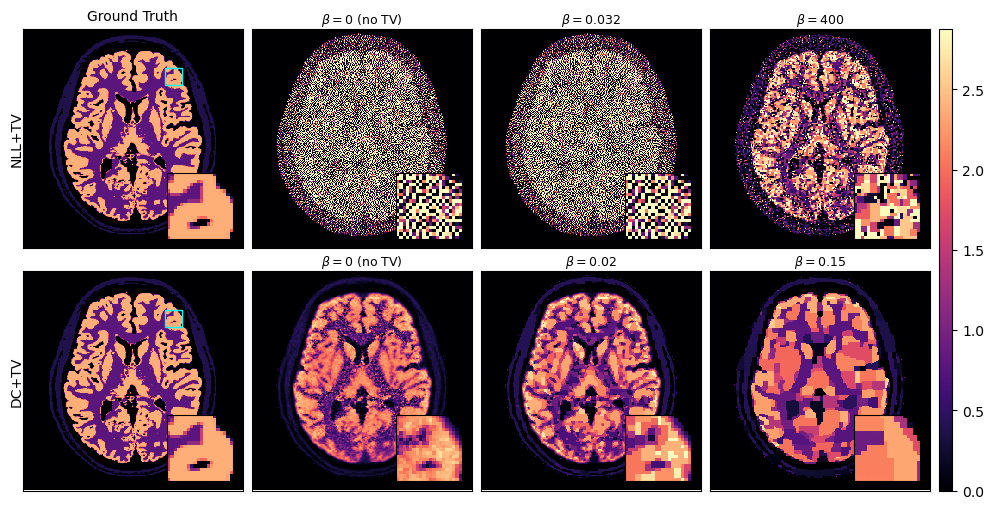

In [20]:
# --- CONFIG ------------------------------------------------------------------
# indices (into the *_images / *_tv_betas lists) to show for each row
# Provide exactly 3 indices per method to fill the 3 beta columns
nll_idxs  = [0, 15, 30]   # example: choose which NLL+TV images to display
dist_idxs = [0, 10, 20]   # example: choose which DC+TV images to display

# y, x (top-left corner of inset)
zoom_coords = (55-10, 175-10)
cmap = "magma"
# -----------------------------------------------------------------------------


import numpy as np
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize

fig = plt.figure(figsize=(12, 6))  # , dpi=600

def _to_array(img):
    """Accepts numpy array or torch tensor; squeezes channel if needed."""
    if hasattr(img, "cpu"):   # torch
        arr = img.detach().cpu().squeeze().numpy() if hasattr(img, "detach") else img.cpu().squeeze().numpy()
    else:
        arr = np.squeeze(np.asarray(img))
    return arr

def add_inset_cutout(ax, image, zoom_coords=(10, 10), patch_size=20, vmin=0, vmax=1):
    r0, c0 = zoom_coords
    patch = image[r0:r0 + patch_size, c0:c0 + patch_size]
    ax_inset = inset_axes(ax, width="30%", height="30%", loc='lower right',
                          bbox_to_anchor=(0, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0.5)
    ax_inset.imshow(patch, cmap=cmap, vmin=vmin, vmax=vmax)
    ax_inset.set_xticks([]); ax_inset.set_yticks([])

# ----- Expect these to exist: phantom, nll_images, nll_tv_betas, dist_images, dist_tv_betas
phant_arr = _to_array(phantom)
vmin, vmax = 0.0, float(np.max(phant_arr) * 1.2)

# 2 rows (methods), 5 cols: [GT | β1 | β2 | β3 | colorbar]
gs = GridSpec(2, 5, width_ratios=[1, 1, 1, 1, 0.06], wspace=0.05, hspace=0.1)
plt.tight_layout()

# ---------------- Ground Truth column (col 0) ----------------
loss_rows = ["nll", "dist"]
row_labels = {"nll": "NLL+TV", "dist": "DC+TV"}

for row, loss_name in enumerate(loss_rows):
    ax_gt = fig.add_subplot(gs[row, 0])
    im_true = ax_gt.imshow(phant_arr, cmap=cmap, vmin=vmin, vmax=vmax)
    if row == 0:
        ax_gt.set_title("Ground Truth", fontsize=10)
    ax_gt.set_ylabel(row_labels.get(loss_name, loss_name), fontsize=10, rotation=90, va='center')

    rect = patches.Rectangle((zoom_coords[1], zoom_coords[0]), 20, 20,
                             linewidth=1.0, edgecolor='cyan', facecolor='none')
    ax_gt.add_patch(rect)
    ax_gt.set_xticks([]); ax_gt.set_yticks([])
    add_inset_cutout(ax_gt, phant_arr, zoom_coords=zoom_coords, patch_size=20, vmin=vmin, vmax=vmax)

# --------------- Per-row image selection & titles (cols 1–3) -----------------
row_to_data = {
    "nll":  (nll_images,  nll_tv_betas,  nll_idxs),
    "dist": (dist_images, dist_tv_betas, dist_idxs),
}

for j, loss_name in enumerate(loss_rows):
    images, betas, idxs = row_to_data[loss_name]

    # safety checks
    if not (len(images) == len(betas)):
        raise ValueError(f"{loss_name}: images and betas must be same length (got {len(images)} vs {len(betas)}).")
    if len(idxs) != 3:
        raise ValueError(f"{loss_name}: please provide exactly 3 indices (got {len(idxs)}).")

    # draw the three chosen images for this row
    for col_offset, k in enumerate(idxs, start=1):
        img = _to_array(images[k])
        beta_val = float(betas[k])

        ax = fig.add_subplot(gs[j, col_offset])
        ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)

        # Row-specific titles using the associated beta for that selected image
        title_txt = (r"$\beta=0$ (no TV)" if beta_val == 0.0 else rf"$\beta={beta_val:g}$")
        ax.set_title(title_txt, fontsize=9, pad=4)

        ax.set_xticks([]); ax.set_yticks([])
        add_inset_cutout(ax, img, zoom_coords=zoom_coords, patch_size=20, vmin=vmin, vmax=vmax)

# ---------------- Right-side colorbar (vector, SVG/dpi-safe) -----------------
cax = fig.add_subplot(gs[:, 4])
norm = Normalize(vmin=vmin, vmax=vmax)
cbar = fig.colorbar(im_true, cax=cax, orientation='vertical')
# keep it vector in SVG so thickness doesn't depend on dpi
cbar.solids.set_rasterized(False)
cbar.solids.set_edgecolor("face")

cbar.ax.tick_params(labelsize=10)
cbar.ax.yaxis.set_ticks_position('right')
cbar.ax.yaxis.set_label_position('right')

# ---------------- Save / show ------------------------------------------------
fig.tight_layout()
fig.canvas.draw()

if SAVEFIG:
    base = os.path.join(save_directory, f"IMG_SIZE_{IMG_SIZE}_PET_images_4x2_beta_from_lists")
    fig.savefig(base + ".svg",  dpi=600, bbox_inches="tight", pad_inches=0)
    fig.savefig(base + "_300.svg", dpi=300, bbox_inches="tight", pad_inches=0)
    fig.savefig(base + "_150.svg", dpi=150, bbox_inches="tight", pad_inches=0)
    fig.savefig(base + ".png",  dpi=600, bbox_inches="tight", pad_inches=0)

plt.show()


### Plot PSNR

In [ ]:
# Plot the PSNR curves

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

cutoff = 0  # Cutoff for the x-axis

x_values = list(range(0, epochs, 1))

x_values_dist = x_values[:len(states["dist"]["losses"]["nrmse"])]

ax.set_xlim(cutoff, x_values[-1])

ax.set_ylim(0.2, 0.5)

ax.plot(x_values, states["nll"]["losses"]["nrmse"], label="NLL-Adam", color='red', alpha=0.8)
ax.plot(x_values_dist, states["dist"]["losses"]["nrmse"], label="DC-Adam", color='blue', alpha=0.8)

ax.set_xlabel("Iterations")
ax.set_ylabel(r"NRMSE $\downarrow$")

ax.legend()
plt.tight_layout()
ax.grid(True)
ax.set_title("Normalized Root Mean Square Error (NRMSE)", fontsize=12)

if SAVEFIG:
    plt.savefig(os.path.join(save_directory, f"IMG_SIZE_{IMG_SIZE}_PET_NRMSE.svg"), dpi=600)
plt.show()


#### Plot SSIM

In [ ]:
# Plot the SSIM curves

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

cutoff = 0  # Cutoff for the x-axis

x_values = list(range(0, epochs, 1))

x_values_dist = x_values[:len(states["dist"]["losses"]["ssim"])]

ax.set_xlim(cutoff, x_values[-1])

ax.plot(x_values, states["nll"]["losses"]["ssim"], label="NLL-Adam", color='red', alpha=0.8)
ax.plot(x_values_dist, states["dist"]["losses"]["ssim"], label="DC-Adam", color='blue', alpha=0.8)

ax.set_xlabel("Iterations")
ax.set_ylabel(r"SSIM $\uparrow$")

ax.grid(True)
ax.set_title("Structural Similarity Index Measure (SSIM)", fontsize=12)
ax.legend()

if SAVEFIG:
    plt.savefig(os.path.join(save_directory, f"IMG_SIZE_{IMG_SIZE}_PET_SSIM.png"), dpi=600)
plt.show()
